# Лабораторная работа №15 Метод сеток решения задачи Дирихле для уравнения Пуассона

## **Введение**

### Цель работы
Цель выполнения задания:
- изучить метод разностных аппроксимаций для уравнения Пуассона;
- составить алгоритмы решения задачи Дирихле для уравнения Пуассона методом сеток применимыми для организации вычислений на ПЭВМ;
- составить программы решения задачи Дирихле для уравнения Пуассона по разработанным алгоритмам;
- выполнить тестовые примеры и проверить правильность работы программ;
- получить численное решение заданной задачи Дирихле для уравнения Пуассона.



### Условия задания

Условия задания были выбраны исходя из варианта

In [59]:
VARIANT_NUMBER = 28

In [64]:
width = 200
height = 140
radius = 35
thickness = 5
P = 70 * 10**9
E = 40
v = 0.3
function = lambda x, y: P / (E * thickness**3 / (12 * (1 - v**2)))

## **Программная реализация**

Характеристики устройства:
* Операционная система: Ubuntu 18.04.4 LTS (Bionic Beaver)
* Процессор: Intel Core i7 8550U
* Объем и тип оперативной памяти: 16 Gb DDR4
* Тип диска, на которой установленна ОС: HDD

В качестве языка программирования использован Python 3.8.5  и среда программирования Jupyter Lab 2.2.7. Использовались библиотеки numpy - для работы с матрицами, scipy.sparse - для работы с разреженными матрицами, matplolib - для визуализации, а также встроенная библиотека с простейшими математическими функциями math.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import typing as tp
import scipy.sparse as spa
import scipy.sparse.linalg as spa_linalg

from math import *

%matplotlib inline

## Задание 1

Требуется следующую промоделировать следующий процесс: пластина прямоугольной формы с вырезом на одной из сторон жестко закреплена по краям и равномерно нагружена по площади, прогиб пластины определяется из уравнения Пуассона. При этом рассчитывается прогиб как функция $W(x, y)$ по данным из варианта: $A$, $B$ – размеры пластины; $h$ − ее толщина; $R$ – радиус выреза; $P$ – нагрузка; $Е$ − модуль упругости; $ν$ – коэффициент Пуассона, граничное условие $W$ = 0. Дифференциальное уравнение Пуассона имеет вид:
$$\frac{\delta^2 w(x, y)}{\delta x^2} + \frac{\delta^2 w(x, y)}{\delta y^2} = \frac{P}{D}$$ 
где $D = \frac{Eh^3}{12(1 - v^2)}$ - изгибная жесткость, $E$ – модуль упругости, $h$− толщина пластины, $ν$ – коэффициент Пуассона.

Для решения данного дифференциального уравнения аппроксимируем вторые производные как:
$$ \frac {\partial^2 u}{\partial x^2} = \frac {u(x+h, y) - 2u(x, y) + u(x-h, y)}{h^2} $$$$ \frac {\partial^2 u}{\partial y^2} = \frac {u(x, y+h) - 2u(x, y) + u(x, y-h)}{y^2} $$
Тогда, для каждого внутреннего узла составим разностную схему вида:
$$\frac{W_{i+1, j} - 2W_{i, j} + W_{i-1, j}}{h^2} + \frac{W_{i, j+1} - 2W_{i, j} + W_{i, j+1}}{h^2} = \frac{P}{D}$$
Упростим выражение:
$$W_{i+1, j} + W_{i-1, j} + W_{i, j+1} + W_{i, j+1} - 4W_{i, j} = \frac{Ph^2}{D}$$
Для остальных (граничных и внешних точек) значение $W_{i, j} = 0$. 
Данную разностную схему можно решать как систему линейных уравнений. При этом решение разностной схемы необходимо представить в виде вектора.

Для более эффективной с точки зрения скорости вычисления и памяти реализации алгоритма необходимо использовать разреженные матрицы (так как на одной строке матрицы ненулевыми будут только 5 значений) и решать такую систему можно при помощи встроенных эффективных алгоритмов для разреженных матриц. В данном случае используется метод сопряжённых градиентов.

In [62]:
def solve(width: float, height: float, radius: float, 
          function: tp.Callable[[float, float], float], step: float) -> np.array:
    cols_amount = int(ceil(width / step)) + 1
    rows_amount = int(ceil(height / step)) + 1
    
    total_equations_amount = cols_amount * rows_amount
    data = []
    i_indexes = []
    j_indexes = []
    
    b = np.zeros(total_equations_amount)
    
    def get_mapped_index(i: int, j: int) -> int:
        return cols_amount * i + j
    
    def is_bound_point(i: int, j: int) -> bool:
        x, y = i * step, j * step
        if np.isclose(x, 0) or np.isclose(y, 0):
            return True
        elif x >= height or y >= width:
            return True
        elif x**2 + (y - width / 2)**2 <= radius ** 2:
            return True
        else:
            return False
    
    
    
    for i in range(rows_amount):
        for j in range(cols_amount):
            if not is_bound_point(i, j):
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j - 1))
    
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j + 1))
    
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i + 1, j))
    
    
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i - 1, j))
    
    
                data.append(-4)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j))
    
                b[get_mapped_index(i, j)] = function(i * step, j * step) * step**2
            else:
                data.append(1)
                i_indexes.append(get_mapped_index(i, j))
                j_indexes.append(get_mapped_index(i, j))
    A = spa.coo_matrix((data, (i_indexes, j_indexes)))
    solution = spa_linalg.cg(A, b)[0]
    return solution.reshape((rows_amount, cols_amount))  

def plot_solution(solution: np.array, width: float, height: float, step: float) -> None:
    y = np.arange(0, height + step, step)
    x = np.arange(0, width + step, step)
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, solution, cmap='summer')

Вычислим решение разностной схемы с шагом  $h=1$

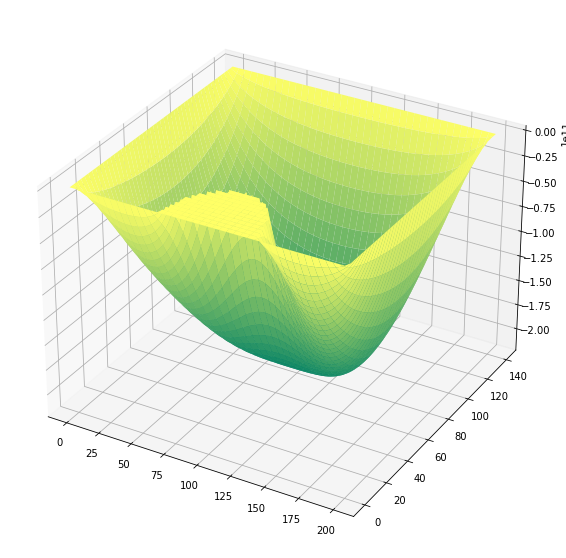

In [68]:
solution = solve(width, height, radius, function, 1)
plot_solution(solution, width, height, 1)

Вычислим решение разностной схемы с шагом 4

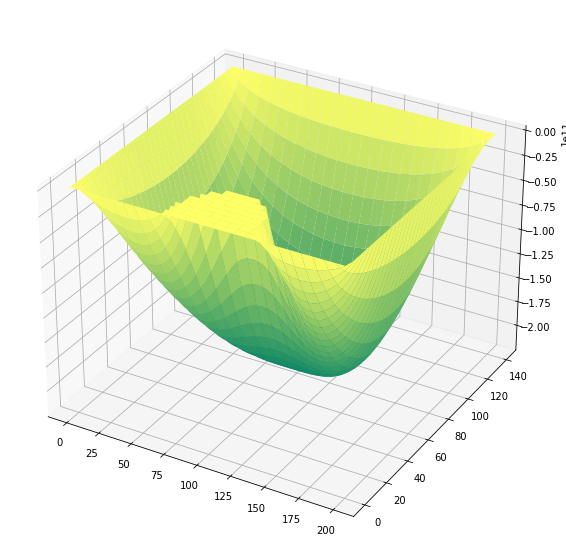

In [71]:
solution = solve(width, height, radius, function, 4)
plot_solution(solution, width, height, 4)

Вычислим решение разностной схемы с шагом 8

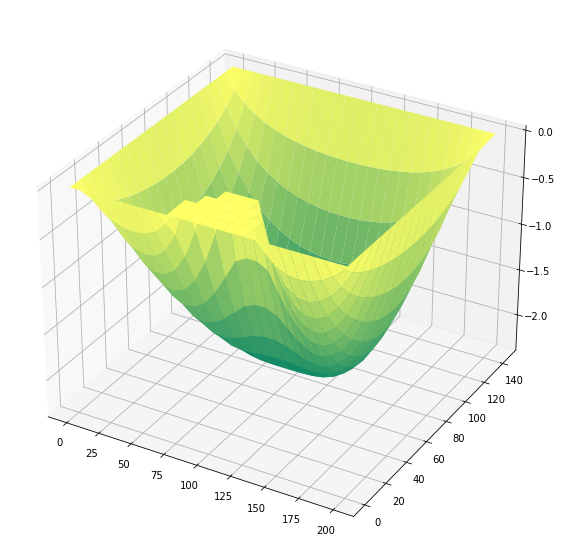

In [74]:
 solution = solve(width, height, radius, function, 8)
plot_solution(solution, width, height, 8)

Как видно из данных графиков, полученный результат соответствует практическим результатам. При этом, при увеличении шага сетки, ухудшается качество аппроксимации функции.

## Вывод

В данной лабораторной работе я разработал функцию для решения задачи Дирихле для уравнения Лапласа и проверил корректность работы на примере реального физического процесса.

При этом, стоит отметить вычислительные особенности разработанного мною алгоритма. При реализации наивного способа решения системы линейных уравнений я столкнулся с проблемами в скорости работы алгоритма, а также проблемами, связанными с ограниченностью оперативной памяти компьютера. Решением данной проблемы стало использование разреженной матрицы формата `coo` (который подходит также к способу заполнения матрицы системы линейных уравнений), а также использование итеративного метода сопряженных градиентов для решения системы линейных уравнений.

В ходе работы я изучил зависимость качества аппроксимации функции от шага разностной сетке, а также получил визуальное подтверждение данной гипотезы в виде графика. 